In [1]:
%%time

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cv2, os, random
import plotly
import plotly.graph_objs as go
import plotly.express as px
from tensorflow.keras import datasets, layers, models
from plotly.offline import init_notebook_mode, plot, iplot

CPU times: total: 4.02 s
Wall time: 5.05 s


In [2]:
import glob
import tensorflow
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, BatchNormalization,Activation
from tensorflow.keras.models import Sequential
#from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,precision_recall_curve
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics 
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import itertools

In [3]:
from tqdm.notebook import tqdm
from termcolor import colored

In [4]:
from warnings import filterwarnings
filterwarnings("ignore")

In [5]:
from sklearn import set_config
set_config(print_changed_only = False)
directory = "C:/Users/antho/Dropbox/PC/Downloads/chest_xray/chest_xray"


In [6]:
%%time

train_df = glob.glob("C:/Users/antho/Dropbox/PC/Downloads/chest_xray/chest_xray/train/**/*.jpeg")
test_df = glob.glob("C:/Users/antho/Dropbox/PC/Downloads/chest_xray/chest_xray/test/**/*.jpeg")
validation_df = glob.glob("C:/Users/antho/Dropbox/PC/Downloads/chest_xray/chest_xray/val/**/*.jpeg")

print(colored("The datasets were succesfully loaded...", color = "green", attrs = ["bold", "dark"]))

The datasets were succesfully loaded...
CPU times: total: 31.2 ms
Wall time: 118 ms


In [7]:
train_df[:5], test_df[:5]

(['C:/Users/antho/Dropbox/PC/Downloads/chest_xray/chest_xray/train\\NORMAL\\IM-0115-0001.jpeg',
  'C:/Users/antho/Dropbox/PC/Downloads/chest_xray/chest_xray/train\\NORMAL\\IM-0117-0001.jpeg',
  'C:/Users/antho/Dropbox/PC/Downloads/chest_xray/chest_xray/train\\NORMAL\\IM-0119-0001.jpeg',
  'C:/Users/antho/Dropbox/PC/Downloads/chest_xray/chest_xray/train\\NORMAL\\IM-0122-0001.jpeg',
  'C:/Users/antho/Dropbox/PC/Downloads/chest_xray/chest_xray/train\\NORMAL\\IM-0125-0001.jpeg'],
 ['C:/Users/antho/Dropbox/PC/Downloads/chest_xray/chest_xray/test\\NORMAL\\IM-0001-0001.jpeg',
  'C:/Users/antho/Dropbox/PC/Downloads/chest_xray/chest_xray/test\\NORMAL\\IM-0003-0001.jpeg',
  'C:/Users/antho/Dropbox/PC/Downloads/chest_xray/chest_xray/test\\NORMAL\\IM-0005-0001.jpeg',
  'C:/Users/antho/Dropbox/PC/Downloads/chest_xray/chest_xray/test\\NORMAL\\IM-0006-0001.jpeg',
  'C:/Users/antho/Dropbox/PC/Downloads/chest_xray/chest_xray/test\\NORMAL\\IM-0007-0001.jpeg'])

In [8]:
print("There is {} images in the training dataset".format(len(train_df)))
print("There is {} images in the test dataset".format(len(test_df)))
print("There is {} images in the validation dataset".format(len(validation_df)))

There is 5216 images in the training dataset
There is 624 images in the test dataset
There is 16 images in the validation dataset


In [9]:
datasets, pneumonia_lung, normal_lung = ["train", "test", "val"], [], []

for i in datasets:
    path = os.path.join(directory, i)
    normal = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneumonia = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    normal_lung.extend(normal), pneumonia_lung.extend(pneumonia)

print("The number of pneumonia images is {}".format(len(pneumonia_lung)))
print("The number of non-pneumonia images is {}".format(len(normal_lung)))

The number of pneumonia images is 4273
The number of non-pneumonia images is 1583


In [10]:
random.shuffle(normal_lung)
random.shuffle(pneumonia_lung)

NORMAL


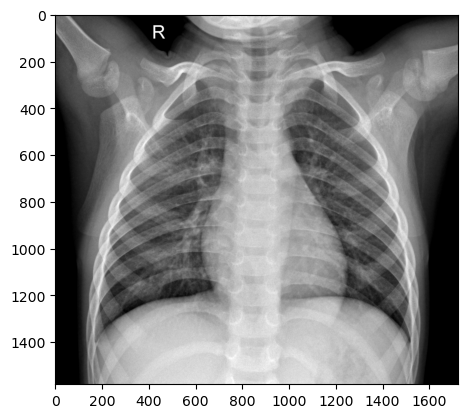

In [11]:
normal_lung_image = load_img("C:/Users/antho/Dropbox/PC/Downloads/chest_xray/chest_xray/train/NORMAL/IM-0135-0001.jpeg")
print("NORMAL")
plt.imshow(normal_lung_image)
plt.show()

PNEUMONIA


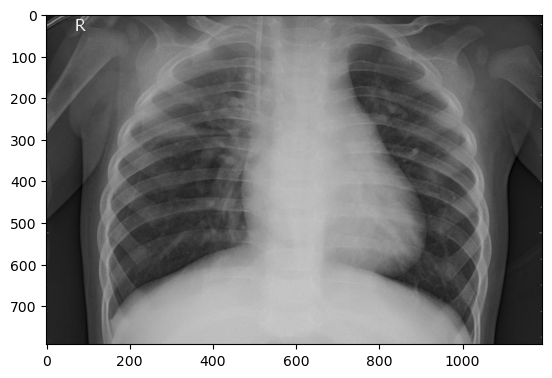

In [12]:
pneu_lung_image = load_img("C:/Users/antho/Dropbox/PC/Downloads/chest_xray/chest_xray/train/PNEUMONIA/person518_bacteria_2198.jpeg")
print("PNEUMONIA")
plt.imshow(pneu_lung_image)
plt.show()

In [13]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 200
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [14]:
train_dir = get_training_data("C:/Users/antho/Dropbox/PC/Downloads/chest_xray/train")
test_dir =get_training_data ("C:/Users/antho/Dropbox/PC/Downloads/chest_xray/test")
validation_dir =get_training_data( "C:/Users/antho/Dropbox/PC/Downloads/chest_xray/val")

In [15]:
X = []
y = []

for feature, label in train_dir:
    X.append(feature)
    y.append(label)

for feature, label in test_dir:
    X.append(feature)
    y.append(label)
    
for feature, label in validation_dir:
    X.append(feature)
    y.append(label)


# resize data for deep learning 
X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=32)

X_train,X_val, X_test = np.array(X_train, np.float32), np.array(X_val, np.float32),np.array(X_test, np.float32)

# resize data for deep learning 
X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=32)


In [16]:
print("There is {} images in the training dataset".format(len(X_train)))
print("There is {} images in the test dataset".format(len(X_test)))
print("There is {} images in the validation dataset".format(len(X_val)))

There is 3747 images in the training dataset
There is 1172 images in the test dataset
There is 937 images in the validation dataset


In [17]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

In [18]:


model1 = Sequential()
model1.add(Conv2D(32, (3, 3), padding='same',input_shape=X_train.shape[1:]))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, (3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dense(1))
model1.add(Activation('softmax'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      320       
                                                                 
 activation (Activation)     (None, 200, 200, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 activation_1 (Activation)   (None, 100, 100, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                    

In [19]:
model1.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [20]:
history = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5)

Epoch 1/5
118/118 [==============================] - 52s 437ms/step - loss: 0.3522 - accuracy: 0.2698 - val_loss: 0.2123 - val_accuracy: 0.2593
Epoch 2/5
118/118 [==============================] - 52s 437ms/step - loss: 0.1534 - accuracy: 0.2698 - val_loss: 0.1840 - val_accuracy: 0.2593
Epoch 3/5
118/118 [==============================] - 52s 444ms/step - loss: 0.1254 - accuracy: 0.2698 - val_loss: 0.1926 - val_accuracy: 0.2593
Epoch 4/5
118/118 [==============================] - 52s 438ms/step - loss: 0.1091 - accuracy: 0.2698 - val_loss: 0.1513 - val_accuracy: 0.2593
Epoch 5/5
118/118 [==============================] - 51s 434ms/step - loss: 0.0944 - accuracy: 0.2698 - val_loss: 0.1822 - val_accuracy: 0.2593


In [21]:
test_loss, test_accuracy = model1.evaluate(X_test,y_test)

37/37 [==============================] - 3s 86ms/step - loss: 0.1618 - accuracy: 0.2807


In [22]:
predictions = (model1.predict(X_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

37/37 [==============================] - 3s 84ms/step


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

[Text(0, 0.5, 'PNEUMONIA'), Text(0, 1.5, 'NORMAL')]

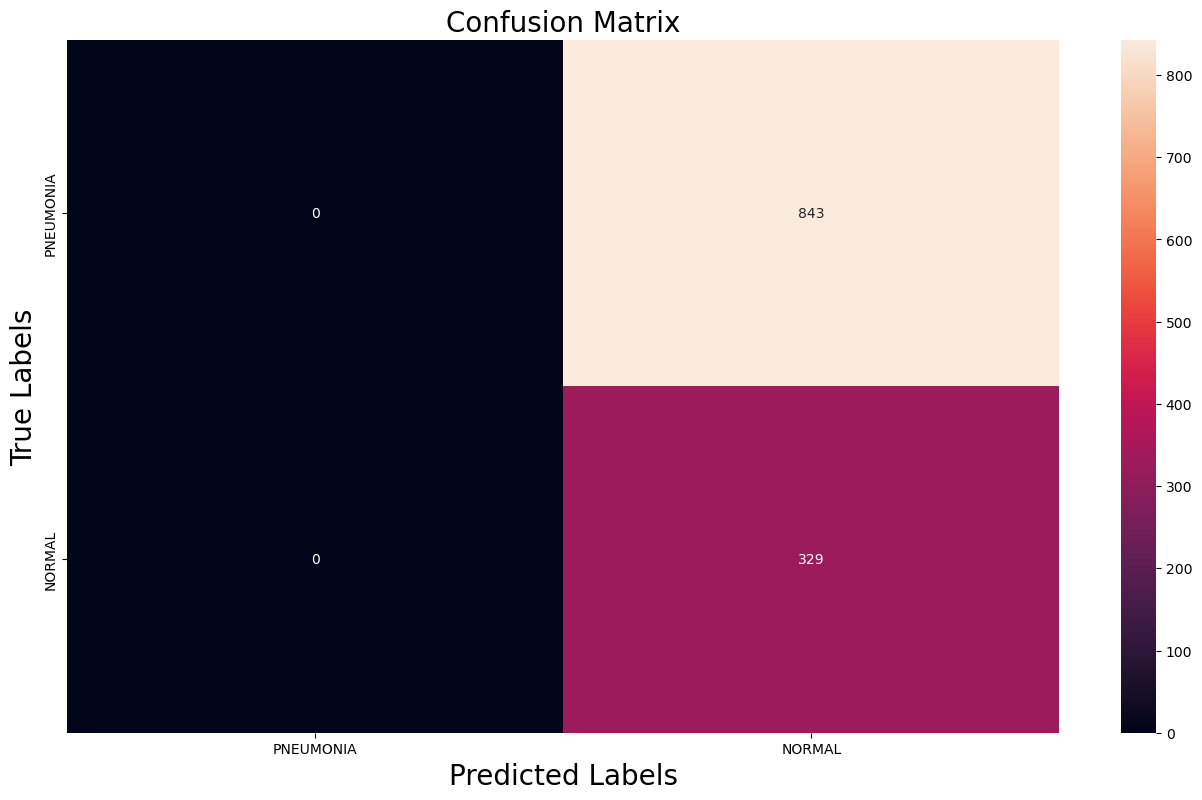

In [23]:
matrix= confusion_matrix(y_test,predictions)
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True,fmt="d", ax = ax)

s# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [24]:
model2 = Sequential()

#convolutional neural networks - CNNs
model2.add(Conv2D(32, (3,3), strides = (1, 1),activation = "relu",  input_shape=X_train.shape[1:], padding='same'))
model2.add(MaxPooling2D(pool_size = (2, 2)))
model2.add(Conv2D(64, (3,3), strides = (1, 1), padding = "same", activation = "relu"))
model2.add(MaxPooling2D(pool_size = (2, 2)))
model2.add(Dropout(0.2))
model2.add(Conv2D(128, (3,3), strides = (1, 1), padding = "same", activation = "relu"))
model2.add(MaxPooling2D(pool_size = (2, 2)))
model2.add(Conv2D(256, (3,3), strides = (1, 1), padding = "same", activation = "relu"))
model2.add(MaxPooling2D(pool_size = (2, 2)))
model2.add(Dropout(0.2))
model2.add(Flatten())


#fully connected layer
model2.add(Dense(128, activation = "relu"))
model2.add(Dense(64, activation = "relu"))
model2.add(Dense(32, activation = "relu"))
model2.add(Dense(1, activation = "sigmoid"))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 200, 200, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 50, 50, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 128)      

In [25]:
model2.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [26]:
history = model2.fit(X_train, y_train, batch_size=100, validation_data=(X_val, y_val), epochs=30)

Epoch 1/30
38/38 [==============================] - 81s 2s/step - loss: 0.5149 - accuracy: 0.7662 - val_loss: 0.3310 - val_accuracy: 0.8666
Epoch 2/30
38/38 [==============================] - 82s 2s/step - loss: 0.2354 - accuracy: 0.9042 - val_loss: 0.1859 - val_accuracy: 0.9328
Epoch 3/30
38/38 [==============================] - 84s 2s/step - loss: 0.1495 - accuracy: 0.9442 - val_loss: 0.1832 - val_accuracy: 0.9349
Epoch 4/30
38/38 [==============================] - 83s 2s/step - loss: 0.1352 - accuracy: 0.9461 - val_loss: 0.2091 - val_accuracy: 0.9253
Epoch 5/30
38/38 [==============================] - 84s 2s/step - loss: 0.1272 - accuracy: 0.9514 - val_loss: 0.1615 - val_accuracy: 0.9402
Epoch 6/30
38/38 [==============================] - 81s 2s/step - loss: 0.1016 - accuracy: 0.9608 - val_loss: 0.1646 - val_accuracy: 0.9424
Epoch 7/30
38/38 [==============================] - 81s 2s/step - loss: 0.1002 - accuracy: 0.9637 - val_loss: 0.1474 - val_accuracy: 0.9488
Epoch 8/30
38/38 [==

In [27]:
test_loss, test_accuracy = model2.evaluate(X_test,y_test)

37/37 [==============================] - 5s 134ms/step - loss: 0.2691 - accuracy: 0.9616


In [28]:
predictions = (model2.predict(X_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

37/37 [==============================] - 5s 132ms/step


array([1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0])

[Text(0, 0.5, 'PNEUMONIA'), Text(0, 1.5, 'NORMAL')]

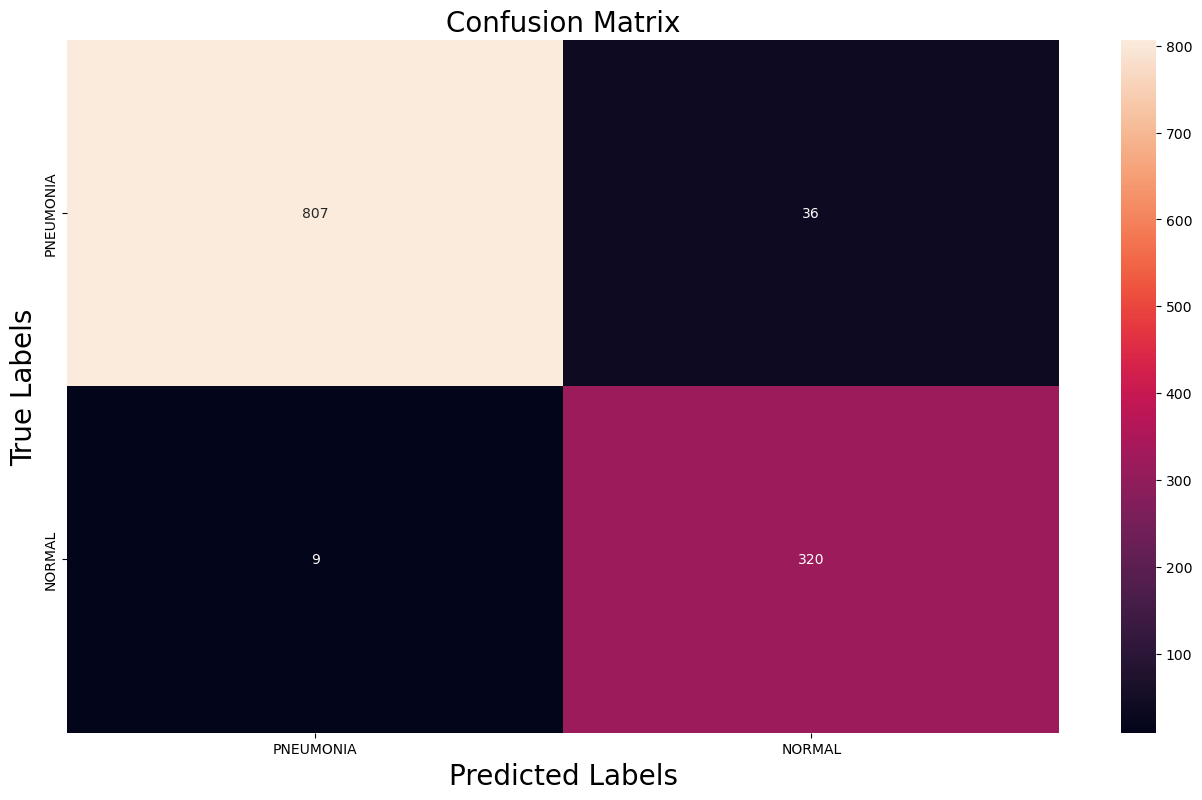

In [29]:
matrix= confusion_matrix(y_test,predictions)
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True,fmt="d", ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

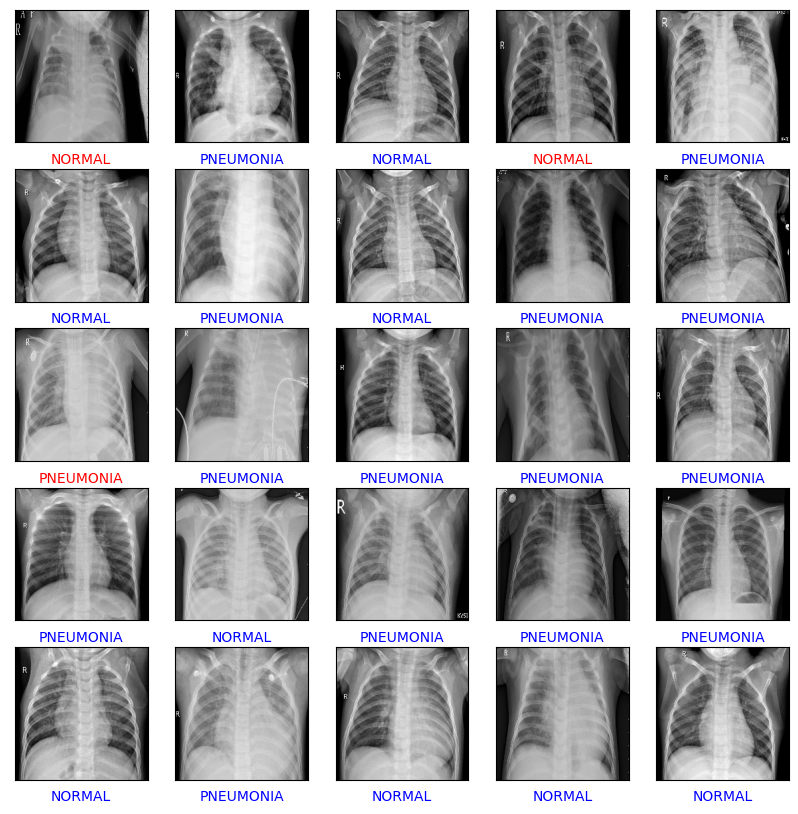

In [30]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train.reshape(-1, img_size, img_size)[i], cmap='gray')
    if(predictions[i]==y_test[i]):
        plt.xlabel(labels[predictions[i]], color='blue')
    else:
        plt.xlabel(labels[predictions[i]], color='red')
plt.show()